## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

### General Libraries

In [ ]:
import numpy as np
import os
import pickle
import pandas as pd
import sys
import math
import multiprocessing as mp
import json
import requests

### Tensorflow and Image Libraries

In [ ]:
# Tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.platform import gfile

# Image
import io
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
cores = mp.cpu_count()

Instructions for updating:
non-resource variables are not supported in the long term


### Keras Libraries

In [ ]:
import sys
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

### Additional Packages required for taking photo in python console

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

### OpenCV & Keras Model load Libraries

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
import copy

## Model Configuration and Parameter

### Raw Data

In [ ]:
emotion_data_path = '/content/drive/My Drive/Colab Notebooks/Others/ML_Lab/dataset/imdb_crop/'
gender_data_path = '/content/drive/My Drive/Colab Notebooks/Others/ML_Lab/dataset/fer2013/'

### Model Directory Path

In [ ]:
MODEL_DIR = '/content/drive/My Drive/Colab Notebooks/Others/ML_Lab/models/'

### Face Detection Model's Parameter

In [ ]:
# TENSORFLOW FACE MODEL DETECTION MODEL FILE
PATH_TO_FACE_DETECTION_MODEL = MODEL_DIR + 'frozen_inference_graph_face.pb'
# Haar cascade file path
CASCADE_FILE_PATH = MODEL_DIR + 'haarcascade_frontalface_default.xml'
# Face Detection Confidence
FACE_DETECTION_CONFIDENCE = 0.50
# Number of classes
NUM_CLASSES = 2
# FRACTION OF GPU MEMORY TO USE FOR DETECTION
FRACTION_GPU_MEMORY_DETECTION = 0.45

### Face Recognition Model's Parameter

In [ ]:
# PATH TO FACE ENCODINGS FILE
PATH_TO_FACE_ENCODINGS_FILE = MODEL_DIR + 'encodings.pickle'
# TENSORFLOW FACE MODEL RECOGNITION MODEL FILE
PATH_TO_FACE_RECOGNITION_MODEL = MODEL_DIR + '20170512-110547.pb'
# FRACTION OF GPU MEMORY TO USE FOR RECOGNITION
FRACTION_GPU_MEMORY_RECOGNITION = 0.45
# FACE RECOGNITION DISTANCE THRESHOLD
DISTANCE_THRESHOLD = 1
# Face recognition percentage threshold
PERCENTGE_THRESHOLD = 70
# Input Image Size
INPUT_IMAGE_SIZE = 160
# minimum face width and height
MIN_FACE_SIZE = 40
# BLURR THRESHOLD
BLURR_THRESHOLD = 100
# known person list for validation
KNOWN_PERSONS_VALIDATION = []

## Image Preprocessing

In [ ]:
class ImageOptimization(object):
    def __init__(self):
        super(ImageOptimization, self).__init__()

    # for illumination correction use this function on cropped face image
    def apply_clahe(self, frame):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
        lab_img = cv2.cvtColor(frame, cv2.COLOR_BGR2Lab)
        lab = cv2.split(lab_img)
        lab[0] = clahe.apply(lab[0])
        _lab_img = cv2.merge(lab)
        rgb_img = cv2.cvtColor(_lab_img, cv2.COLOR_Lab2RGB)
        bgr_img = cv2.cvtColor(_lab_img, cv2.COLOR_Lab2BGR)
        # return bgr image
        return bgr_img

    # use this function to apply clache to cropped
    def apply_clahe_face(self, img, mtcnn_face):
        # mtcnn_face = mtcnn_faces[0] # x1,y1,x2,y2
        x1, y1, x2, y2 = mtcnn_face
        h, w = img.shape[:2]
        h_face = y2 - y1
        w_face = x2 - x1
        del_w = int(0.1 * float(w_face))
        del_h = int(0.1 * float(h_face))
        _x1 = max(0, x1 - del_w)
        _x2 = min(w - 1, x2 + del_w)
        _y1 = max(0, y1 - del_h)
        _y2 = min(h - 1, y2 + del_h)
        face = img[_y1:_y2, _x1:_x2]
        clahe_face = self.apply_clahe(face)
        clahe_img = img.copy()
        clahe_img[_y1:_y2, _x1:_x2] = clahe_face
        return clahe_img

    # this function applies 2D rotation
    def align_face_eyes(self, img, eyes):
        # angle between eyes
        dY = eyes[1][1] - eyes[0][1]
        dX = eyes[1][0] - eyes[0][0]
        angle = -np.degrees(np.arctan2(dY, dX))
        face_aligned_img = rotate_bound(img.copy(), angle)
        return face_aligned_img

    # for image brightness adjustment
    def adjust_gamma(self, img, gamma=1.0):
        """
        :param img  : give an input image
        :param gamma: desired gamma value
        :return LUt : look-up-table for pixel wise gamma correction
        """
        inv_gamma = 1.0 / gamma
        # building a lookup table
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 255)]).astype('uint8')
        # applying gamma correction using lookup table
        return cv2.LUT(img, table)

## Loading & Matching Data

In [ ]:
class IdData(object):
    """Keeps track of known identities and calculates id matches"""

    def __init__(self):
        # Initializing the parameters
        self.distance_threshold = DISTANCE_THRESHOLD
        self.names = []
        self.known_encodings = []

    def fetchKnownEncodings(self, path):
        """getting the known encoding from a pickle file"""
        try:
            if os.path.exists(path) and os.path.getsize(path) > 0:
                with open(path, 'rb') as fr:
                    [self.names, self.known_encodings] = pickle.load(fr)
        except Exception as e:
            print('Exception occured in reading from Pickle file:' + e)
    
    def saveEncoding(self, path, name, image):
        """saving known encoding to a pickle file"""
        try:
            data = tRecognition.getFace(image)
            print('Encodings successfully calculated!')
            if len(data) > 1:
                raise Exception('More than one person in the image found')
            if os.path.exists(path):
                with open(path, 'rb') as fr:
                    [self.names, self.known_encodings] = pickle.load(fr)
                    self.names.append(name)
                    self.known_encodings.append(data[0]['embeddings'][0])
                    with open(path, 'wb') as fw:
                        pickle.dump([self.names, self.known_encodings], fw, protocol=pickle.HIGHEST_PROTOCOL)
                    print('File saved')
            else:
                self.names.append(name)
                self.known_encodings.append(data[0]['embeddings'][0])
                with open(path, 'wb') as fw:
                    pickle.dump([self.names, self.known_encodings], fw, protocol=pickle.HIGHEST_PROTOCOL)
                print('File saved')
        except Exception as e:
            print('Exception occured in reading from Pickle file:' + e)
    
    def findPeople(self, features_arr, thres=0.5, percent_thres=PERCENTGE_THRESHOLD):
        """
        :param features_arr: a list of 128d Features of all faces on screen
        :param thres: distance threshold
        :param percent_thres: confidence percentage
        :return: person name and percentage
        """
        data_set = id_data.known_encodings
        known_persons = id_data.names
        returnRes = []
        for data in features_arr:
            result = "Unknown"
            smallest = sys.maxsize
            for (i, person_data) in enumerate(data_set):
                distance = np.sqrt(np.sum(np.square(person_data - data['embeddings'][0])))
                if distance < smallest:
                    smallest = distance
                    result = known_persons[i]
            percentage = min(100, 100 * thres / smallest)
            if percentage <= percent_thres:
                result = "Unknown"
            returnRes.append((result, percentage))
        return returnRes

## Face Detection Model

In [ ]:
class TensoflowFaceDector(object):
    def __init__(self, PATH_TO_CKPT):
        """Tensorflow detector
        """
        print('Face Detection model loading...')
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            model_exp = os.path.expanduser(PATH_TO_CKPT)
            # print('Model filename: %s' % model_exp)
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        with self.detection_graph.as_default():
            # fraction of GPU memory to use
            gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=FRACTION_GPU_MEMORY_DETECTION)
            # gpu_config = tf.ConfigProto(gpu_options=gpu_options)
            gpu_config = tf.ConfigProto()
            
            gpu_config.intra_op_parallelism_threads = cores  # no of physical cpu cores to allocate
            gpu_config.intra_op_parallelism_threads = cores  # no of physical cpu cores to allocate
            gpu_config.gpu_options.allow_growth = True

            self.sess = tf.Session(graph=self.detection_graph, config=gpu_config)
            # writer = tf.summary.FileWriter('./tf_logs/face_detection', self.sess.graph)
            self.windowNotSet = True
            print('Face Detection model loaded!')
            


    def run(self, image):
        """image: bgr image
        return (boxes, scores, classes, num_detections)
        """
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = self.sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        return boxes, scores, classes, num_detections


class FacePose(object):
    """docstring for FacePose"""

    def __init__(self, cascade_file_path):
        super(FacePose, self).__init__()
        # load cascade classifier training file for lbpcascade
        FacePose.haar_face_cascade = cv2.CascadeClassifier(cascade_file_path)

    @classmethod
    def detect_faces(cls, rgb_face_patch, scaleFactor=1.1):
        # making a copy of the original image
        img_copy = rgb_face_patch.copy()

        # convert the test image to gray image as opencv face detector expects gray images
        gray_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

        # let's detect multiscale (some images may be closer to camera than others) images
        faces = FacePose.haar_face_cascade.detectMultiScale(gray_img, scaleFactor=scaleFactor, minNeighbors=5)

        return faces

## Face Recognition Model

In [ ]:
class TensorflowFaceRecognition(object):

    def __init__(self, MODEL_PATH):
        print('Face Recognition model loading...')
        self.recognition_graph = tf.Graph()
        with self.recognition_graph.as_default():
            model_exp = os.path.expanduser(MODEL_PATH)
            if os.path.isfile(model_exp):
                # print('Model filename: %s' % model_exp)
                with gfile.FastGFile(model_exp, 'rb') as f:
                    graph_def = tf.GraphDef()
                    graph_def.ParseFromString(f.read())
                    tf.import_graph_def(graph_def, input_map=None, name='')
                    # Get input and output tensors
                    self.images_placeholder = self.recognition_graph.get_tensor_by_name("input:0")
                    self.embeddings = self.recognition_graph.get_tensor_by_name("embeddings:0")
                    self.phase_train_placeholder = self.recognition_graph.get_tensor_by_name("phase_train:0")
                    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=config.FRACTION_GPU_MEMORY_RECOGNITION)
                    # # creating the tensorflow session
                    # self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
                    self.sess = tf.Session()
                    print('Face Recognition model loaded!')
                    # writer = tf.summary.FileWriter('./tf_logs/face_recognition', self.sess.graph)
            else:
                print('Model directory: %s' % model_exp)
                meta_file, ckpt_file = get_model_filenames(model_exp)

                print('Metagraph file: %s' % meta_file)
                print('Checkpoint file: %s' % ckpt_file)

                saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file), input_map=input_map)
                saver.restore(self.recognition_graph.get_default_session(), os.path.join(model_exp, ckpt_file))

    def getEmbedding(self, resized, input_image_size=INPUT_IMAGE_SIZE):
        """Calculating the embedding for a face patch"""
        reshaped = resized.reshape(-1, input_image_size, input_image_size, 3)
        feed_dict = {self.images_placeholder: reshaped, self.phase_train_placeholder: False}
        embedding = self.sess.run(self.embeddings, feed_dict=feed_dict)
        return embedding
    
    def findCosineSimilarity(self, vector_1, vector_2):
        a = np.matmul(np.transpose(vector_1), vector_2)
        b = np.sum(np.multiply(vector_1, vector_2))
        c = np.sum(np.multiply(vector_1, vector_2))
        return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    
    def l2_normalize(self, x):
        return x / np.sqrt(np.sum(np.multiply(x, x)))
    
    def prewhiten(self, x):
        """Normalzing the face patch"""
        mean = np.mean(x)
        std = np.std(x)
        std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
        y = np.multiply(np.subtract(x, mean), 1 / std_adj)
        return y

    def detect_face(self, img, thres=FACE_DETECTION_CONFIDENCE, input_image_size=INPUT_IMAGE_SIZE):
        h, w = img.shape[:2]
        bbs = []
        (boxes, scores, classes, num_detections) = tDetector.run(img)
        boxes = np.squeeze(boxes)
        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)
        for i in range(boxes.shape[0]):
            if scores is None or scores[i] > thres:
                box = tuple(boxes[i].tolist())
                ymin, xmin, ymax, xmax = box
                left, right, top, bottom = xmin * w, xmax * w, ymin * h, ymax * h
                left, right, top, bottom = int(left), int(right), int(top), int(bottom)
                if right - left >= MIN_FACE_SIZE and bottom - top >= MIN_FACE_SIZE:
                    bbs.append([int(left), int(top), int(right), int(bottom)])
        return bbs

    def getFace(self, img, thres=FACE_DETECTION_CONFIDENCE, input_image_size=INPUT_IMAGE_SIZE):
        faces = []
        bbs = self.detect_face(img)
        for left, top, right, bottom in bbs:
            # cropping the face patch from the frame
            cropped = img[top:bottom, left:right, :]
            # resizing the cropped image to the input_image_size
            resized = cv2.resize(cropped, (input_image_size, input_image_size), interpolation=cv2.INTER_CUBIC)
            # normalizing the image
            prewhitened = self.prewhiten(resized)
            # making the output
            faces.append(
                {'face': resized, 'rect': (left, top, right, bottom),
                    'embeddings': self.getEmbedding(prewhitened)})
        return faces

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

## Initialization of Face Detection and Recognition Model

In [ ]:
tDetector = TensoflowFaceDector(PATH_TO_FACE_DETECTION_MODEL)
tRecognition = TensorflowFaceRecognition(PATH_TO_FACE_RECOGNITION_MODEL)

Face Detection model loading...
Face Detection model loaded!
Face Recognition model loading...
Instructions for updating:
Use tf.gfile.GFile.
Face Recognition model loaded!


## Take Photo in Python Console

In [ ]:
def take_photo(filename='your name.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Click here to recognize your Emotion';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        // console.log(canvas.width)
        canvas.height = video.videoHeight;
        // console.log(canvas.height)
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    img = np.frombuffer(binary, np.uint8)
    # use numpy to construct an array from the bytes
    # x = np.fromstring(buf, dtype='uint8') 
    #decode the array into an image
    img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)
    # write file to disk
    # with open(filename, 'wb') as f:
    # f.write(binary)
    return img

# Emotion Analysis

### Gender Detection Model

In [ ]:
# set recursionlimit and seed
sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)

In [ ]:
class WideResNet:
    def __init__(self, image_size, depth=16, k=8):
        self._depth = depth
        self._k = k
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"
        self._channel_axis = -1
        self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)

        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        flatten = Flatten()(pool)
        predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)
        predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)

        model = Model(inputs=inputs, outputs=[predictions_g, predictions_a])

        return model

### Emotion Detection Model

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def get_labels(dataset_name):
    if dataset_name == 'fer2013':
        return {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    elif dataset_name == 'imdb':
        return {0: 'Woman', 1: 'Man'}
    elif dataset_name == 'KDEF':
        return {0: 'AN', 1: 'DI', 2: 'AF', 3: 'HA', 4: 'SA', 5: 'SU', 6: 'NE'}
    else:
        raise Exception('Invalid dataset name')
def Extract_Emotion(face_obj):
    img_to_analysis = take_photo()
    image_rgb = cv2.cvtColor(img_to_analysis, cv2.COLOR_BGR2RGB)
    image = face_obj.detect_face_char(image_rgb)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2_imshow(image)

In [ ]:
class FaceImage(object):
    WRN_WEIGHTS_PATH = "https://github.com/Tony607/Keras_age_gender/releases/download/V1.0/weights.18-4.06.hdf5"
    EMOTION_MODEL_PATH = 'fer2013_mini_XCEPTION.119-0.65.hdf5'

    def __new__(cls, weight_file=None, depth=16, width=8, face_size=64):
        if not hasattr(cls, 'instance'):
            cls.instance = super(FaceImage, cls).__new__(cls)
        return cls.instance

    def __init__(self, depth=16, width=8, face_size=64):
        self.face_size = face_size
        print("Loading gender model...")
        self.model = WideResNet(face_size, depth=depth, k=width)()
        model_dir = os.path.join(os.getcwd(), "models").replace("//", "\\")
        fpath = get_file('weights.18-4.06.hdf5',
                         self.WRN_WEIGHTS_PATH,
                         cache_subdir=model_dir)
        self.model.load_weights(fpath)
        print("Gender model Loaded")

        print('Loading emotion model...')
        os.system('wget https://github.com/oarriaga/face_classification/raw/master/trained_models/fer2013_mini_XCEPTION.119-0.65.hdf5')
        self.emotion_labels = get_labels('fer2013')
        self.emotion_classifier = load_model(self.EMOTION_MODEL_PATH, compile=False)
        self.emotion_target_size = self.emotion_classifier.input_shape[1:3]
        # self.emotion_offsets = (20, 40)
        print('Emotion model loaded')

    @classmethod
    def draw_label_bottom(cls, image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
                   font_scale=0.5, thickness=1, row_index=0, alpha=0.5):
        size = cv2.getTextSize(label, font, font_scale, thickness)[0]
        point = (point[0], point[1] + (row_index * size[1]))
        x, y = point
        overlay = image.copy()
        cv2.rectangle(overlay, (x, y), (x + size[0], y + size[1]), (255, 0, 0), cv2.FILLED)
        point = x, y+size[1]
        cv2.putText(overlay, label, point, font, font_scale, (255, 255, 255), thickness)
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
        
    def get_regular_face(self, img, bb):
        return img[bb[1]:bb[3], bb[0]:bb[2], :]

    def get_expanded_face(self, img, bb):
        img_h, img_w, _ = np.shape(img)
        x1, y1, x2, y2 = bb
        w, h = x2 - x1, y2 - y1
        xw1 = max(int(x1 - 0.4 * w), 0)
        yw1 = max(int(y1 - 0.4 * h), 0)
        xw2 = min(int(x2 + 0.4 * w), img_w - 1)
        yw2 = min(int(y2 + 0.4 * h), img_h - 1)
        return cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (self.face_size, self.face_size))

    def detect_face_char(self, img):
        # workaround for CV2 bug
        img = copy.deepcopy(img)
        
        input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_h, img_w, _ = np.shape(input_img)

        # for face detection
        face_bbs = tRecognition.detect_face(input_img)

        expanded_face_imgs = np.empty((len(face_bbs), self.face_size, self.face_size, 3))
        emotion2_results = []
  
        # Get face images      
        for i, bb in enumerate(face_bbs):
            x1, y1, x2, y2 = bb
            w, h = x2 - x1, y2 - y1
            expanded_face_imgs[i, :, :, :] = self.get_expanded_face(img, bb)
            reg_face = self.get_regular_face(img, bb)
            gray_face = gray_image[y1:y2, x1:x2]
            
            gray_face = cv2.resize(gray_face, (self.emotion_target_size))

            gray_face = preprocess_input(gray_face, True)
            gray_face = np.expand_dims(gray_face, 0)
            gray_face = np.expand_dims(gray_face, -1)
            emotion_prediction = self.emotion_classifier.predict(gray_face)
            emotion_probability = np.max(emotion_prediction)
            emotion_label_arg = np.argmax(emotion_prediction)
            emotion_text = self.emotion_labels[emotion_label_arg]
            emotion2_results.append(emotion_text)

        
        if len(expanded_face_imgs) > 0:
            # predict ages and genders of the detected faces
            results = self.model.predict(expanded_face_imgs)
            predicted_genders = results[0]
            ages = np.arange(0, 101).reshape(101, 1)
            predicted_ages = results[1].dot(ages).flatten()
            
        # draw results
        for i, bb in enumerate(face_bbs):
        
            ## Display age, gender and emotion 
            label2 = "{}, {}".format(emotion2_results[i], "Female" if predicted_genders[i][0] > 0.5 else "Male")
        
            # label2 = "{}, {}, {}".format(int(predicted_ages[i]),
            #                              "F" if predicted_genders[i][0] > 0.5 else "M",
            #                              emotion2_results[i])
                    
            self.draw_label_bottom(img, (bb[0], bb[1]), label2, row_index=0)

        # draw face rectangles
        for i, bb in enumerate(face_bbs):
            x1, y1, x2, y2 = bb
            w, h = x2 - x1, y2 - y1
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        return img


## Create an object for Emotion and Gender Detection model

In [ ]:
face_obj = FaceImage()

Loading gender model...
Instructions for updating:
Colocations handled automatically by placer.
195813376/195810464 [==============================] - 588s 3us/step
Gender model Loaded
Loading emotion model...
Emotion model loaded


## Check your Emotion and Gender

<IPython.core.display.Javascript object>

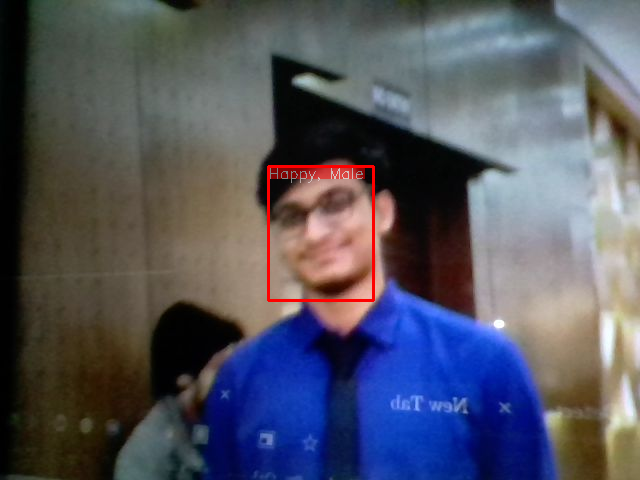

In [ ]:
Extract_Emotion(face_obj)